# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

ModuleNotFoundError: No module named 'jaxlib'

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [ ]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 3
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [ ]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [ ]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels, classes = create_labeled_training_classes(training_data, classification, workload)
test_data_labels = create_labeled_test_validation_classes(test_data, classes, workload)
validation_data_labels = create_labeled_test_validation_classes(validation_data, classes, workload)

## Model

In [ ]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [ ]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)
        #print(predictions, labels)
        
        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [ ]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [ ]:
EPOCHS = 10000
initial_number_of_circuits = 20
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_1_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 10 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Initializing new parameters


Progress:  0.045
Number of training circuits: 20   Number of validation circuits: 82   Number of test circuits: 78   Number of parameters in model: 202
0.01 0.01


Epoch: 200   train/loss: 4.2933   valid/loss: 22.7805   train/acc: 0.2   valid/acc: 0.1098
Epoch: 400   train/loss: 4.0362   valid/loss: 24.159   train/acc: 0.15   valid/acc: 0.1098
Epoch: 600   train/loss: 3.8465   valid/loss: 24.4325   train/acc: 0.15   valid/acc: 0.1341
Epoch: 800   train/loss: 3.8827   valid/loss: 24.3819   train/acc: 0.35   valid/acc: 0.0854
Epoch: 1000   train/loss: 3.7854   valid/loss: 24.1904   train/acc: 0.25   valid/acc: 0.1463
Epoch: 1200   train/loss: 3.7466   valid/loss: 24.2107   train/acc: 0.3   valid/acc: 0.0976
Epoch: 1400   train/loss: 3.736   valid/loss: 24.4524   train/acc: 0.35   valid/acc: 0.1098
Epoch: 1600   train/loss: 3.6369   valid/loss: 24.7901   train/acc: 0.4   valid/acc: 0.1463
Epoch: 1800   train/loss: 3.5735   valid/loss: 24.6498   train/acc: 0.3   valid/acc: 0.0976
Epoch: 2000   train/loss: 3.6247   valid/loss: 25.117   train/acc: 0.3   valid/acc: 0.1098
Epoch: 2200   train/loss: 3.6075   valid/loss: 25.0278   train/acc: 0.3   valid/ac

Test accuracy: 0.15384615384615385
Progress:  0.047
Number of training circuits: 21   Number of validation circuits: 82   Number of test circuits: 81   Number of parameters in model: 205
Progress:  0.049
Number of training circuits: 22   Number of validation circuits: 82   Number of test circuits: 81   Number of parameters in model: 205
Progress:  0.051
Number of training circuits: 23   Number of validation circuits: 82   Number of test circuits: 81   Number of parameters in model: 205
Progress:  0.054
Number of training circuits: 24   Number of validation circuits: 82   Number of test circuits: 81   Number of parameters in model: 205
Progress:  0.056
Number of training circuits: 25   Number of validation circuits: 82   Number of test circuits: 81   Number of parameters in model: 205
Progress:  0.058
Number of training circuits: 26   Number of validation circuits: 85   Number of test circuits: 86   Number of parameters in model: 208
Progress:  0.06
Number of training circuits: 27   Num

Epoch: 200   train/loss: 9.6877   valid/loss: 25.57   train/acc: 0.1795   valid/acc: 0.1354
Epoch: 400   train/loss: 9.5188   valid/loss: 25.1316   train/acc: 0.1282   valid/acc: 0.0625
Epoch: 600   train/loss: 9.4876   valid/loss: 25.1808   train/acc: 0.1282   valid/acc: 0.1458
Epoch: 800   train/loss: 9.4803   valid/loss: 25.1022   train/acc: 0.0769   valid/acc: 0.1667
Epoch: 1000   train/loss: 9.4162   valid/loss: 25.0731   train/acc: 0.0769   valid/acc: 0.1042
Epoch: 1200   train/loss: 9.3623   valid/loss: 25.1362   train/acc: 0.2051   valid/acc: 0.125
Epoch: 1400   train/loss: 9.255   valid/loss: 24.9848   train/acc: 0.2051   valid/acc: 0.1667
Epoch: 1600   train/loss: 9.2564   valid/loss: 24.9758   train/acc: 0.1795   valid/acc: 0.1562
Epoch: 1800   train/loss: 9.1699   valid/loss: 24.8866   train/acc: 0.1538   valid/acc: 0.1354
Epoch: 2000   train/loss: 9.0806   valid/loss: 24.8016   train/acc: 0.1538   valid/acc: 0.125
Epoch: 2200   train/loss: 9.1408   valid/loss: 24.8455   tr

Test accuracy: 0.11224489795918367
Progress:  0.089
Number of training circuits: 40   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.092
Number of training circuits: 41   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.094
Number of training circuits: 42   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.096
Number of training circuits: 43   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.098
Number of training circuits: 44   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.1
Number of training circuits: 45   Number of validation circuits: 99   Number of test circuits: 101   Number of parameters in model: 229
Progress:  0.103
Number of training circuits: 46 

Epoch: 200   train/loss: 14.0222   valid/loss: 29.0362   train/acc: 0.2203   valid/acc: 0.1748
Epoch: 400   train/loss: 13.2932   valid/loss: 29.1796   train/acc: 0.1864   valid/acc: 0.165
Epoch: 600   train/loss: 12.9557   valid/loss: 29.5697   train/acc: 0.2373   valid/acc: 0.2039
Epoch: 800   train/loss: 12.3827   valid/loss: 28.9938   train/acc: 0.3051   valid/acc: 0.165
Epoch: 1000   train/loss: 11.969   valid/loss: 29.6674   train/acc: 0.2712   valid/acc: 0.2136
Epoch: 1200   train/loss: 11.5874   valid/loss: 30.5886   train/acc: 0.2542   valid/acc: 0.165
Epoch: 1400   train/loss: 11.2787   valid/loss: 30.6202   train/acc: 0.2373   valid/acc: 0.1359
Epoch: 1600   train/loss: 11.0643   valid/loss: 31.4378   train/acc: 0.2203   valid/acc: 0.1456
Epoch: 1800   train/loss: 10.8452   valid/loss: 32.0431   train/acc: 0.3559   valid/acc: 0.0874
Epoch: 2000   train/loss: 10.9053   valid/loss: 32.93   train/acc: 0.339   valid/acc: 0.1068
Epoch: 2200   train/loss: 10.8109   valid/loss: 33.

Test accuracy: 0.12380952380952381
Progress:  0.134
Number of training circuits: 60   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.136
Number of training circuits: 61   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.138
Number of training circuits: 62   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.141
Number of training circuits: 63   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.143
Number of training circuits: 64   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.145
Number of training circuits: 65   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.147
Number of training circu

Epoch: 200   train/loss: 17.4533   valid/loss: 28.6365   train/acc: 0.2821   valid/acc: 0.1942
Epoch: 400   train/loss: 16.1407   valid/loss: 29.4958   train/acc: 0.2564   valid/acc: 0.165
Epoch: 600   train/loss: 15.6898   valid/loss: 30.5213   train/acc: 0.2308   valid/acc: 0.0971
Epoch: 800   train/loss: 15.5314   valid/loss: 31.1438   train/acc: 0.3077   valid/acc: 0.1262
Epoch: 1000   train/loss: 15.3676   valid/loss: 30.4607   train/acc: 0.2821   valid/acc: 0.1165
Epoch: 1200   train/loss: 15.2189   valid/loss: 30.9211   train/acc: 0.2564   valid/acc: 0.0874
Epoch: 1400   train/loss: 15.0988   valid/loss: 32.1522   train/acc: 0.2308   valid/acc: 0.1165
Epoch: 1600   train/loss: 15.1909   valid/loss: 31.7293   train/acc: 0.3077   valid/acc: 0.1262
Epoch: 1800   train/loss: 14.9583   valid/loss: 32.7858   train/acc: 0.2949   valid/acc: 0.1456
Epoch: 2000   train/loss: 14.9997   valid/loss: 33.9716   train/acc: 0.359   valid/acc: 0.1553
Epoch: 2200   train/loss: 14.8647   valid/loss

Test accuracy: 0.11428571428571428
Progress:  0.179
Number of training circuits: 79   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.181
Number of training circuits: 80   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.183
Number of training circuits: 81   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.185
Number of training circuits: 82   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.188
Number of training circuits: 83   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.19
Number of training circuits: 84   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.192
Number of training circui

Epoch: 200   train/loss: 22.5611   valid/loss: 28.176   train/acc: 0.2062   valid/acc: 0.1456
Epoch: 400   train/loss: 21.2931   valid/loss: 29.1468   train/acc: 0.2887   valid/acc: 0.0971
Epoch: 600   train/loss: 20.2857   valid/loss: 30.666   train/acc: 0.2474   valid/acc: 0.165
Epoch: 800   train/loss: 20.0066   valid/loss: 32.2064   train/acc: 0.2062   valid/acc: 0.1456
Epoch: 1000   train/loss: 19.5923   valid/loss: 30.6727   train/acc: 0.2371   valid/acc: 0.1553
Epoch: 1200   train/loss: 19.3822   valid/loss: 32.5906   train/acc: 0.3093   valid/acc: 0.1359
Epoch: 1400   train/loss: 19.2702   valid/loss: 31.9318   train/acc: 0.3093   valid/acc: 0.1068
Epoch: 1600   train/loss: 19.2783   valid/loss: 31.7875   train/acc: 0.2784   valid/acc: 0.1748
Epoch: 1800   train/loss: 19.1652   valid/loss: 32.1961   train/acc: 0.2784   valid/acc: 0.1262
Epoch: 2000   train/loss: 19.0105   valid/loss: 31.5783   train/acc: 0.2268   valid/acc: 0.1262
Epoch: 2200   train/loss: 18.9828   valid/loss:

Test accuracy: 0.1523809523809524
Progress:  0.223
Number of training circuits: 98   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 232
Progress:  0.225
Number of training circuits: 99   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.228
Number of training circuits: 100   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.23
Number of training circuits: 101   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.232
Number of training circuits: 102   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.234
Number of training circuits: 103   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.237
Number of training cir

Epoch: 200   train/loss: 28.9871   valid/loss: 26.311   train/acc: 0.1624   valid/acc: 0.2136
Epoch: 400   train/loss: 28.756   valid/loss: 26.6423   train/acc: 0.1538   valid/acc: 0.1748
Epoch: 600   train/loss: 28.6498   valid/loss: 26.4767   train/acc: 0.1282   valid/acc: 0.2233
Epoch: 800   train/loss: 28.5481   valid/loss: 26.4528   train/acc: 0.1111   valid/acc: 0.1262
Epoch: 1000   train/loss: 28.3561   valid/loss: 26.6394   train/acc: 0.1709   valid/acc: 0.2039
Epoch: 1200   train/loss: 28.2456   valid/loss: 26.704   train/acc: 0.1709   valid/acc: 0.1553
Epoch: 1400   train/loss: 28.1803   valid/loss: 26.8559   train/acc: 0.1453   valid/acc: 0.1456
Epoch: 1600   train/loss: 28.1324   valid/loss: 27.0787   train/acc: 0.1453   valid/acc: 0.2039
Epoch: 1800   train/loss: 28.1107   valid/loss: 26.7174   train/acc: 0.1709   valid/acc: 0.165
Epoch: 2000   train/loss: 27.9816   valid/loss: 26.7772   train/acc: 0.1624   valid/acc: 0.1165
Epoch: 2200   train/loss: 27.891   valid/loss: 2

Test accuracy: 0.10476190476190476
Progress:  0.268
Number of training circuits: 118   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.27
Number of training circuits: 119   Number of validation circuits: 103   Number of test circuits: 105   Number of parameters in model: 235
Progress:  0.272
Number of training circuits: 120   Number of validation circuits: 104   Number of test circuits: 106   Number of parameters in model: 238
Progress:  0.275
Number of training circuits: 121   Number of validation circuits: 104   Number of test circuits: 106   Number of parameters in model: 238
Progress:  0.277
Number of training circuits: 122   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 247
Progress:  0.279
Number of training circuits: 123   Number of validation circuits: 105   Number of test circuits: 106   Number of parameters in model: 247
Progress:  0.281
Number of training 

Epoch: 200   train/loss: 33.8967   valid/loss: 29.3352   train/acc: 0.1606   valid/acc: 0.0943
Epoch: 400   train/loss: 33.0873   valid/loss: 29.5578   train/acc: 0.1679   valid/acc: 0.1509
Epoch: 600   train/loss: 32.5744   valid/loss: 32.3647   train/acc: 0.146   valid/acc: 0.1226
Epoch: 800   train/loss: 32.2115   valid/loss: 31.191   train/acc: 0.1606   valid/acc: 0.1321
Epoch: 1000   train/loss: 31.9014   valid/loss: 31.0429   train/acc: 0.2117   valid/acc: 0.0755
Epoch: 1200   train/loss: 31.7731   valid/loss: 32.273   train/acc: 0.2044   valid/acc: 0.1226
Epoch: 1400   train/loss: 31.7268   valid/loss: 30.5226   train/acc: 0.2336   valid/acc: 0.1132
Epoch: 1600   train/loss: 31.5217   valid/loss: 30.8287   train/acc: 0.1971   valid/acc: 0.1321
Epoch: 1800   train/loss: 31.4767   valid/loss: 30.5329   train/acc: 0.1971   valid/acc: 0.1509
Epoch: 2000   train/loss: 31.2602   valid/loss: 30.7262   train/acc: 0.1898   valid/acc: 0.1415
Epoch: 2200   train/loss: 31.1957   valid/loss:

Test accuracy: 0.09345794392523364
Progress:  0.312
Number of training circuits: 138   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.315
Number of training circuits: 139   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.317
Number of training circuits: 140   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.319
Number of training circuits: 141   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.321
Number of training circuits: 142   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.324
Number of training circuits: 143   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.326
Number of training

Epoch: 200   train/loss: 39.3414   valid/loss: 29.1704   train/acc: 0.1465   valid/acc: 0.1132
Epoch: 400   train/loss: 37.9934   valid/loss: 28.5563   train/acc: 0.1465   valid/acc: 0.1038
Epoch: 600   train/loss: 37.5584   valid/loss: 29.936   train/acc: 0.2038   valid/acc: 0.1604
Epoch: 800   train/loss: 36.1411   valid/loss: 30.0463   train/acc: 0.2229   valid/acc: 0.1415
Epoch: 1000   train/loss: 35.4951   valid/loss: 30.9162   train/acc: 0.242   valid/acc: 0.1038
Epoch: 1200   train/loss: 35.1818   valid/loss: 31.4155   train/acc: 0.2803   valid/acc: 0.0849
Epoch: 1400   train/loss: 35.0341   valid/loss: 31.1573   train/acc: 0.2548   valid/acc: 0.1132
Epoch: 1600   train/loss: 34.727   valid/loss: 31.5334   train/acc: 0.2293   valid/acc: 0.1226
Epoch: 1800   train/loss: 34.6226   valid/loss: 32.129   train/acc: 0.2739   valid/acc: 0.1321
Epoch: 2000   train/loss: 34.4366   valid/loss: 31.3606   train/acc: 0.2166   valid/acc: 0.1038
Epoch: 2200   train/loss: 34.3769   valid/loss: 

Test accuracy: 0.102803738317757
Progress:  0.357
Number of training circuits: 158   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.359
Number of training circuits: 159   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.362
Number of training circuits: 160   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.364
Number of training circuits: 161   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.366
Number of training circuits: 162   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.368
Number of training circuits: 163   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 262
Progress:  0.371
Number of training c

Epoch: 200   train/loss: 44.2976   valid/loss: 28.6245   train/acc: 0.125   valid/acc: 0.2037
Epoch: 400   train/loss: 43.5361   valid/loss: 29.2949   train/acc: 0.1932   valid/acc: 0.1296
Epoch: 600   train/loss: 42.8495   valid/loss: 30.1534   train/acc: 0.1648   valid/acc: 0.1389
Epoch: 800   train/loss: 42.6364   valid/loss: 30.156   train/acc: 0.1534   valid/acc: 0.1296
Epoch: 1000   train/loss: 42.4442   valid/loss: 30.0981   train/acc: 0.1534   valid/acc: 0.1111
Epoch: 1200   train/loss: 42.1173   valid/loss: 30.5359   train/acc: 0.1761   valid/acc: 0.1389
Epoch: 1400   train/loss: 42.0407   valid/loss: 30.7343   train/acc: 0.1705   valid/acc: 0.1389
Epoch: 1600   train/loss: 41.6785   valid/loss: 30.4365   train/acc: 0.1989   valid/acc: 0.1296
Epoch: 1800   train/loss: 41.4892   valid/loss: 30.6124   train/acc: 0.1989   valid/acc: 0.1296
Epoch: 2000   train/loss: 41.3727   valid/loss: 30.3583   train/acc: 0.1705   valid/acc: 0.1019
Epoch: 2200   train/loss: 41.2609   valid/loss

Test accuracy: 0.12037037037037036
Progress:  0.402
Number of training circuits: 177   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.404
Number of training circuits: 178   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.406
Number of training circuits: 179   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.408
Number of training circuits: 180   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.411
Number of training circuits: 181   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.413
Number of training circuits: 182   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.415
Number of training

Epoch: 200   train/loss: 50.3976   valid/loss: 29.403   train/acc: 0.1633   valid/acc: 0.1204
Epoch: 400   train/loss: 48.9334   valid/loss: 29.4146   train/acc: 0.1939   valid/acc: 0.1204
Epoch: 600   train/loss: 47.7489   valid/loss: 29.3192   train/acc: 0.2143   valid/acc: 0.1481
Epoch: 800   train/loss: 47.7722   valid/loss: 28.8614   train/acc: 0.2092   valid/acc: 0.1852
Epoch: 1000   train/loss: 46.9836   valid/loss: 29.1941   train/acc: 0.1684   valid/acc: 0.1204
Epoch: 1200   train/loss: 46.4702   valid/loss: 29.6693   train/acc: 0.1939   valid/acc: 0.0741
Epoch: 1400   train/loss: 46.4241   valid/loss: 30.0238   train/acc: 0.1531   valid/acc: 0.0463
Epoch: 1600   train/loss: 46.0004   valid/loss: 30.2075   train/acc: 0.1684   valid/acc: 0.1389
Epoch: 1800   train/loss: 46.0982   valid/loss: 30.1312   train/acc: 0.2092   valid/acc: 0.1019
Epoch: 2000   train/loss: 45.7273   valid/loss: 29.6904   train/acc: 0.1939   valid/acc: 0.0833
Epoch: 2200   train/loss: 45.6763   valid/los

Test accuracy: 0.1574074074074074
Progress:  0.446
Number of training circuits: 197   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.449
Number of training circuits: 198   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.451
Number of training circuits: 199   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.453
Number of training circuits: 200   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.455
Number of training circuits: 201   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.458
Number of training circuits: 202   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.46
Number of training c

Epoch: 200   train/loss: 54.507   valid/loss: 27.7127   train/acc: 0.1528   valid/acc: 0.1759
Epoch: 400   train/loss: 56.7931   valid/loss: 29.0341   train/acc: 0.1157   valid/acc: 0.0833
Epoch: 600   train/loss: 53.8935   valid/loss: 27.6898   train/acc: 0.1991   valid/acc: 0.1667
Epoch: 800   train/loss: 53.8428   valid/loss: 28.1777   train/acc: 0.1759   valid/acc: 0.1296
Epoch: 1000   train/loss: 54.7951   valid/loss: 27.9142   train/acc: 0.1296   valid/acc: 0.1667
Epoch: 1200   train/loss: 52.7817   valid/loss: 28.7457   train/acc: 0.213   valid/acc: 0.0833
Epoch: 1400   train/loss: 51.892   valid/loss: 29.2011   train/acc: 0.1852   valid/acc: 0.1111
Epoch: 1600   train/loss: 51.6275   valid/loss: 29.4172   train/acc: 0.2361   valid/acc: 0.0556
Epoch: 1800   train/loss: 51.1223   valid/loss: 29.5355   train/acc: 0.2315   valid/acc: 0.0741
Epoch: 2000   train/loss: 50.586   valid/loss: 30.0408   train/acc: 0.2315   valid/acc: 0.0833
Epoch: 2200   train/loss: 50.3641   valid/loss: 

Test accuracy: 0.14814814814814814
Progress:  0.491
Number of training circuits: 216   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.493
Number of training circuits: 216   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.496
Number of training circuits: 217   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.498
Number of training circuits: 218   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.5
Number of training circuits: 219   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.502
Number of training circuits: 220   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.504
Number of training c

Epoch: 200   train/loss: 58.9645   valid/loss: 27.982   train/acc: 0.1288   valid/acc: 0.0648
Epoch: 400   train/loss: 58.4999   valid/loss: 29.4538   train/acc: 0.176   valid/acc: 0.1667
Epoch: 600   train/loss: 58.28   valid/loss: 29.5398   train/acc: 0.176   valid/acc: 0.1019
Epoch: 800   train/loss: 56.8197   valid/loss: 28.3344   train/acc: 0.1631   valid/acc: 0.0648
Epoch: 1000   train/loss: 57.0288   valid/loss: 28.2125   train/acc: 0.1545   valid/acc: 0.1204
Epoch: 1200   train/loss: 56.5583   valid/loss: 28.4302   train/acc: 0.1717   valid/acc: 0.1389
Epoch: 1400   train/loss: 56.7275   valid/loss: 28.5957   train/acc: 0.1845   valid/acc: 0.1389
Epoch: 1600   train/loss: 55.7826   valid/loss: 28.6837   train/acc: 0.1931   valid/acc: 0.0648
Epoch: 1800   train/loss: 55.2045   valid/loss: 29.1125   train/acc: 0.2017   valid/acc: 0.1204
Epoch: 2000   train/loss: 54.8933   valid/loss: 29.2205   train/acc: 0.1803   valid/acc: 0.1204
Epoch: 2200   train/loss: 54.7704   valid/loss: 2

Test accuracy: 0.18518518518518517
Progress:  0.536
Number of training circuits: 234   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.538
Number of training circuits: 235   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.54
Number of training circuits: 236   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.542
Number of training circuits: 237   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.545
Number of training circuits: 238   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.547
Number of training circuits: 239   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.549
Number of training 

Epoch: 200   train/loss: 65.4454   valid/loss: 28.1704   train/acc: 0.1621   valid/acc: 0.0648
Epoch: 400   train/loss: 65.1211   valid/loss: 28.5827   train/acc: 0.1423   valid/acc: 0.0648
Epoch: 600   train/loss: 64.8043   valid/loss: 28.2813   train/acc: 0.1225   valid/acc: 0.0741
Epoch: 800   train/loss: 64.6774   valid/loss: 28.6809   train/acc: 0.1383   valid/acc: 0.0833
Epoch: 1000   train/loss: 64.4878   valid/loss: 28.6704   train/acc: 0.1542   valid/acc: 0.037
Epoch: 1200   train/loss: 65.0009   valid/loss: 28.0228   train/acc: 0.1423   valid/acc: 0.1019
Epoch: 1400   train/loss: 63.7652   valid/loss: 28.3887   train/acc: 0.1542   valid/acc: 0.1019
Epoch: 1600   train/loss: 62.8859   valid/loss: 28.7252   train/acc: 0.1542   valid/acc: 0.1111
Epoch: 1800   train/loss: 62.6811   valid/loss: 28.8388   train/acc: 0.1858   valid/acc: 0.1019
Epoch: 2000   train/loss: 62.704   valid/loss: 28.4702   train/acc: 0.17   valid/acc: 0.0833
Epoch: 2200   train/loss: 62.8405   valid/loss: 

Test accuracy: 0.1574074074074074
Progress:  0.58
Number of training circuits: 254   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.583
Number of training circuits: 255   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.585
Number of training circuits: 256   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.587
Number of training circuits: 257   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.589
Number of training circuits: 258   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.592
Number of training circuits: 259   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.594
Number of training c

Epoch: 200   train/loss: 70.2947   valid/loss: 28.245   train/acc: 0.1465   valid/acc: 0.1389
Epoch: 400   train/loss: 68.1303   valid/loss: 29.1792   train/acc: 0.1575   valid/acc: 0.0833
Epoch: 600   train/loss: 67.7189   valid/loss: 29.0112   train/acc: 0.1758   valid/acc: 0.0926
Epoch: 800   train/loss: 67.5082   valid/loss: 28.2995   train/acc: 0.1758   valid/acc: 0.0463
Epoch: 1000   train/loss: 67.0991   valid/loss: 28.4196   train/acc: 0.1722   valid/acc: 0.0833
Epoch: 1200   train/loss: 66.3839   valid/loss: 28.5136   train/acc: 0.1648   valid/acc: 0.0926
Epoch: 1400   train/loss: 65.7505   valid/loss: 29.2131   train/acc: 0.1685   valid/acc: 0.0741
Epoch: 1600   train/loss: 64.6442   valid/loss: 29.9241   train/acc: 0.1685   valid/acc: 0.1111
Epoch: 1800   train/loss: 64.3841   valid/loss: 29.8664   train/acc: 0.2198   valid/acc: 0.1019
Epoch: 2000   train/loss: 64.2577   valid/loss: 29.6127   train/acc: 0.1868   valid/acc: 0.0833
Epoch: 2200   train/loss: 63.7236   valid/los

Test accuracy: 0.12962962962962962
Progress:  0.625
Number of training circuits: 274   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.627
Number of training circuits: 275   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.629
Number of training circuits: 276   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.632
Number of training circuits: 277   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.634
Number of training circuits: 278   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.636
Number of training circuits: 279   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.638
Number of training

Epoch: 200   train/loss: 74.5803   valid/loss: 28.0018   train/acc: 0.1229   valid/acc: 0.0926
Epoch: 400   train/loss: 73.73   valid/loss: 28.4023   train/acc: 0.1536   valid/acc: 0.1481
Epoch: 600   train/loss: 73.1349   valid/loss: 28.6461   train/acc: 0.1672   valid/acc: 0.1296
Epoch: 800   train/loss: 72.3275   valid/loss: 29.1436   train/acc: 0.1843   valid/acc: 0.0926
Epoch: 1000   train/loss: 71.4282   valid/loss: 29.4002   train/acc: 0.198   valid/acc: 0.0648
Epoch: 1200   train/loss: 71.016   valid/loss: 29.4527   train/acc: 0.1502   valid/acc: 0.0833
Epoch: 1400   train/loss: 70.5011   valid/loss: 29.5197   train/acc: 0.1945   valid/acc: 0.0648
Epoch: 1600   train/loss: 70.827   valid/loss: 29.5557   train/acc: 0.1809   valid/acc: 0.0833
Epoch: 1800   train/loss: 70.2465   valid/loss: 29.3633   train/acc: 0.2184   valid/acc: 0.1019
Epoch: 2000   train/loss: 69.6016   valid/loss: 28.6592   train/acc: 0.2184   valid/acc: 0.1111
Epoch: 2200   train/loss: 69.6637   valid/loss: 2

Test accuracy: 0.1574074074074074
Progress:  0.67
Number of training circuits: 294   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.672
Number of training circuits: 295   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.674
Number of training circuits: 296   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.676
Number of training circuits: 297   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.679
Number of training circuits: 298   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.681
Number of training circuits: 299   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.683
Number of training c

Epoch: 200   train/loss: 81.4251   valid/loss: 28.3563   train/acc: 0.147   valid/acc: 0.1019
Epoch: 400   train/loss: 79.8475   valid/loss: 27.514   train/acc: 0.1182   valid/acc: 0.1019
Epoch: 600   train/loss: 78.2753   valid/loss: 27.8514   train/acc: 0.1789   valid/acc: 0.1667
Epoch: 800   train/loss: 77.5849   valid/loss: 29.3483   train/acc: 0.1853   valid/acc: 0.0926
Epoch: 1000   train/loss: 76.1461   valid/loss: 28.9426   train/acc: 0.1949   valid/acc: 0.0833
Epoch: 1200   train/loss: 76.3119   valid/loss: 29.0084   train/acc: 0.2077   valid/acc: 0.0741
Epoch: 1400   train/loss: 75.4516   valid/loss: 29.1934   train/acc: 0.2141   valid/acc: 0.1204
Epoch: 1600   train/loss: 74.2219   valid/loss: 28.7686   train/acc: 0.2204   valid/acc: 0.0926
Epoch: 1800   train/loss: 73.9288   valid/loss: 29.0443   train/acc: 0.2236   valid/acc: 0.0833
Epoch: 2000   train/loss: 73.2937   valid/loss: 29.4555   train/acc: 0.2332   valid/acc: 0.1667
Epoch: 2200   train/loss: 72.8975   valid/loss

Test accuracy: 0.1574074074074074
Progress:  0.714
Number of training circuits: 314   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.717
Number of training circuits: 315   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.719
Number of training circuits: 316   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.721
Number of training circuits: 317   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.723
Number of training circuits: 318   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.725
Number of training circuits: 319   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.728
Number of training 

Epoch: 200   train/loss: 85.1003   valid/loss: 28.0833   train/acc: 0.1411   valid/acc: 0.1111
Epoch: 400   train/loss: 85.4957   valid/loss: 28.1278   train/acc: 0.1321   valid/acc: 0.1759
Epoch: 600   train/loss: 83.5463   valid/loss: 27.9312   train/acc: 0.1712   valid/acc: 0.1204
Epoch: 800   train/loss: 83.5566   valid/loss: 28.5159   train/acc: 0.1502   valid/acc: 0.0278
Epoch: 1000   train/loss: 83.5154   valid/loss: 29.1779   train/acc: 0.1381   valid/acc: 0.0926
Epoch: 1200   train/loss: 82.3775   valid/loss: 28.505   train/acc: 0.1592   valid/acc: 0.1019
Epoch: 1400   train/loss: 82.3653   valid/loss: 27.9809   train/acc: 0.1802   valid/acc: 0.1759
Epoch: 1600   train/loss: 83.4663   valid/loss: 28.0572   train/acc: 0.1592   valid/acc: 0.1389
Epoch: 1800   train/loss: 82.2376   valid/loss: 28.2247   train/acc: 0.1441   valid/acc: 0.1574
Epoch: 2000   train/loss: 81.2732   valid/loss: 28.0135   train/acc: 0.1802   valid/acc: 0.1204
Epoch: 2200   train/loss: 80.6145   valid/los

Test accuracy: 0.09259259259259259
Progress:  0.759
Number of training circuits: 334   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.761
Number of training circuits: 335   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.763
Number of training circuits: 336   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 265
Progress:  0.766
Number of training circuits: 337   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.768
Number of training circuits: 338   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.77
Number of training circuits: 339   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.772
Number of training 

Epoch: 200   train/loss: 91.8384   valid/loss: 29.256   train/acc: 0.1473   valid/acc: 0.1296
Epoch: 400   train/loss: 90.3816   valid/loss: 28.2787   train/acc: 0.1445   valid/acc: 0.1389
Epoch: 600   train/loss: 90.6886   valid/loss: 28.9066   train/acc: 0.1161   valid/acc: 0.1019
Epoch: 800   train/loss: 88.762   valid/loss: 28.7188   train/acc: 0.17   valid/acc: 0.1296
Epoch: 1000   train/loss: 88.0593   valid/loss: 28.4962   train/acc: 0.153   valid/acc: 0.1019
Epoch: 1200   train/loss: 87.1142   valid/loss: 28.9787   train/acc: 0.153   valid/acc: 0.0648
Epoch: 1400   train/loss: 86.327   valid/loss: 28.534   train/acc: 0.1955   valid/acc: 0.0741
Epoch: 1600   train/loss: 85.8587   valid/loss: 28.9926   train/acc: 0.204   valid/acc: 0.1481
Epoch: 1800   train/loss: 84.8369   valid/loss: 28.731   train/acc: 0.1983   valid/acc: 0.1852
Epoch: 2000   train/loss: 84.8263   valid/loss: 29.0539   train/acc: 0.221   valid/acc: 0.1296
Epoch: 2200   train/loss: 84.1267   valid/loss: 28.6836

Test accuracy: 0.1574074074074074
Progress:  0.804
Number of training circuits: 354   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.806
Number of training circuits: 355   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.808
Number of training circuits: 356   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.81
Number of training circuits: 357   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.812
Number of training circuits: 358   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.815
Number of training circuits: 359   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.817
Number of training c

Epoch: 200   train/loss: 95.2547   valid/loss: 28.2482   train/acc: 0.2016   valid/acc: 0.1204
Epoch: 400   train/loss: 95.7174   valid/loss: 28.3148   train/acc: 0.1505   valid/acc: 0.0926
Epoch: 600   train/loss: 95.3974   valid/loss: 28.5776   train/acc: 0.1048   valid/acc: 0.1204
Epoch: 800   train/loss: 94.1669   valid/loss: 28.7686   train/acc: 0.164   valid/acc: 0.1111
Epoch: 1000   train/loss: 94.1816   valid/loss: 28.8625   train/acc: 0.1559   valid/acc: 0.1667
Epoch: 1200   train/loss: 93.7529   valid/loss: 28.0228   train/acc: 0.1586   valid/acc: 0.1667
Epoch: 1400   train/loss: 93.3568   valid/loss: 29.6707   train/acc: 0.1882   valid/acc: 0.1389
Epoch: 1600   train/loss: 92.8319   valid/loss: 29.5606   train/acc: 0.1559   valid/acc: 0.1296
Epoch: 1800   train/loss: 92.9303   valid/loss: 29.2966   train/acc: 0.207   valid/acc: 0.1019
Epoch: 2000   train/loss: 92.244   valid/loss: 29.3296   train/acc: 0.1801   valid/acc: 0.1111
Epoch: 2200   train/loss: 91.728   valid/loss: 

Test accuracy: 0.08333333333333333
Progress:  0.848
Number of training circuits: 373   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.85
Number of training circuits: 374   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.853
Number of training circuits: 375   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.855
Number of training circuits: 376   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.857
Number of training circuits: 377   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.859
Number of training circuits: 378   Number of validation circuits: 108   Number of test circuits: 108   Number of parameters in model: 277
Progress:  0.862
Number of training 

Epoch: 200   train/loss: 100.4504   valid/loss: 27.8217   train/acc: 0.1173   valid/acc: 0.1019
Epoch: 400   train/loss: 100.6262   valid/loss: 27.77   train/acc: 0.125   valid/acc: 0.1111
Epoch: 600   train/loss: 99.1927   valid/loss: 28.2472   train/acc: 0.1658   valid/acc: 0.1574
Epoch: 800   train/loss: 99.5588   valid/loss: 27.9251   train/acc: 0.1352   valid/acc: 0.1111
Epoch: 1000   train/loss: 99.0417   valid/loss: 27.2266   train/acc: 0.1811   valid/acc: 0.2315
Epoch: 1200   train/loss: 96.7724   valid/loss: 26.663   train/acc: 0.1811   valid/acc: 0.1667
Epoch: 1400   train/loss: 96.5051   valid/loss: 27.4237   train/acc: 0.1199   valid/acc: 0.1296
Epoch: 1600   train/loss: 96.9578   valid/loss: 27.732   train/acc: 0.1454   valid/acc: 0.1389
Epoch: 1800   train/loss: 95.8792   valid/loss: 27.7777   train/acc: 0.1837   valid/acc: 0.1481
Epoch: 2000   train/loss: 95.3278   valid/loss: 28.0468   train/acc: 0.2015   valid/acc: 0.1296
Epoch: 2200   train/loss: 94.6921   valid/loss:

Test accuracy: 0.10185185185185185
Progress:  0.893
Number of training circuits: 393   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.895
Number of training circuits: 394   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.897
Number of training circuits: 395   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.9
Number of training circuits: 396   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.902
Number of training circuits: 397   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.904
Number of training circuits: 398   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.906
Number of training c

Epoch: 200   train/loss: 106.1673   valid/loss: 28.526   train/acc: 0.1189   valid/acc: 0.0833
Epoch: 400   train/loss: 105.5994   valid/loss: 27.8406   train/acc: 0.1408   valid/acc: 0.0741
Epoch: 600   train/loss: 104.6504   valid/loss: 28.5947   train/acc: 0.1286   valid/acc: 0.1759
Epoch: 800   train/loss: 104.1727   valid/loss: 28.985   train/acc: 0.1602   valid/acc: 0.1296
Epoch: 1000   train/loss: 104.0246   valid/loss: 28.1682   train/acc: 0.1408   valid/acc: 0.1204
Epoch: 1200   train/loss: 101.8043   valid/loss: 28.4897   train/acc: 0.1505   valid/acc: 0.1204
Epoch: 1400   train/loss: 100.6765   valid/loss: 28.7826   train/acc: 0.1917   valid/acc: 0.1296
Epoch: 1600   train/loss: 100.3772   valid/loss: 27.9104   train/acc: 0.199   valid/acc: 0.1944
Epoch: 1800   train/loss: 99.4737   valid/loss: 27.9215   train/acc: 0.1942   valid/acc: 0.1574
Epoch: 2000   train/loss: 99.5207   valid/loss: 27.9266   train/acc: 0.1893   valid/acc: 0.1019
Epoch: 2200   train/loss: 98.5947   val

Test accuracy: 0.2018348623853211
Progress:  0.938
Number of training circuits: 413   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.94
Number of training circuits: 414   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.942
Number of training circuits: 415   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.944
Number of training circuits: 416   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.946
Number of training circuits: 417   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.949
Number of training circuits: 418   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.951
Number of training c

Epoch: 200   train/loss: 110.5083   valid/loss: 28.0323   train/acc: 0.1806   valid/acc: 0.0833
Epoch: 400   train/loss: 111.1682   valid/loss: 28.2582   train/acc: 0.1713   valid/acc: 0.0648
Epoch: 600   train/loss: 110.8899   valid/loss: 28.2747   train/acc: 0.169   valid/acc: 0.1019
Epoch: 800   train/loss: 108.7892   valid/loss: 28.4986   train/acc: 0.2037   valid/acc: 0.1111
Epoch: 1000   train/loss: 108.0885   valid/loss: 28.5668   train/acc: 0.1852   valid/acc: 0.1019
Epoch: 1200   train/loss: 106.6384   valid/loss: 28.2098   train/acc: 0.1991   valid/acc: 0.1296
Epoch: 1400   train/loss: 105.8039   valid/loss: 28.5586   train/acc: 0.1968   valid/acc: 0.1111
Epoch: 1600   train/loss: 104.798   valid/loss: 28.2724   train/acc: 0.1921   valid/acc: 0.1481
Epoch: 1800   train/loss: 105.6325   valid/loss: 29.2514   train/acc: 0.1991   valid/acc: 0.1204
Epoch: 2000   train/loss: 103.6773   valid/loss: 28.4378   train/acc: 0.2153   valid/acc: 0.1481
Epoch: 2200   train/loss: 103.8247  

Test accuracy: 0.21100917431192662
Progress:  0.982
Number of training circuits: 433   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.984
Number of training circuits: 434   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.987
Number of training circuits: 435   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.989
Number of training circuits: 436   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.991
Number of training circuits: 437   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.993
Number of training circuits: 438   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 280
Progress:  0.996
Number of training

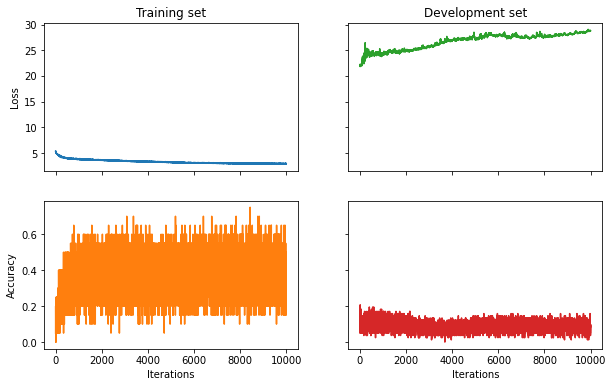

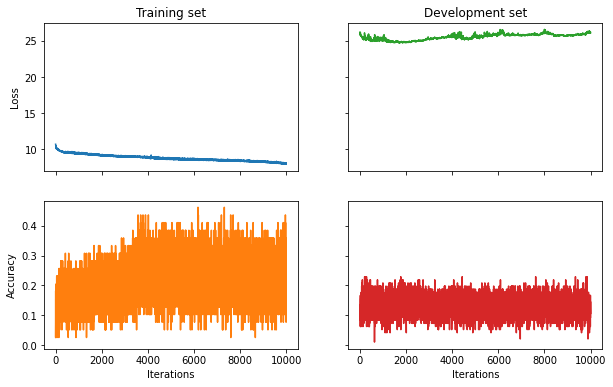

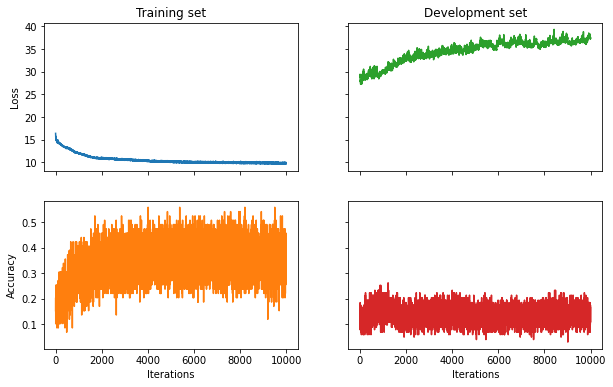

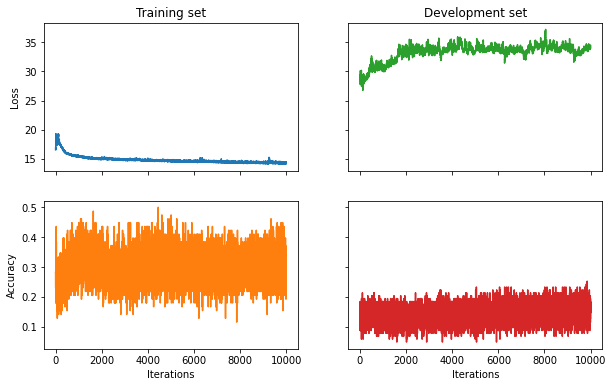

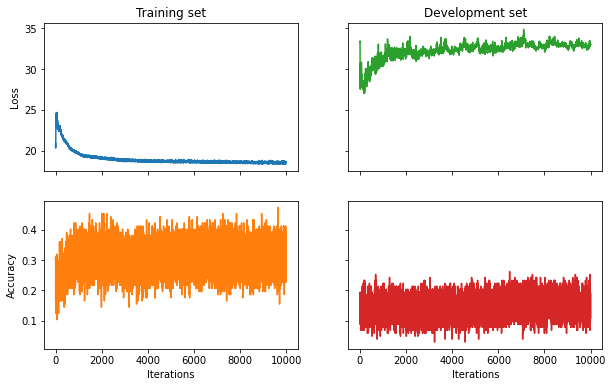

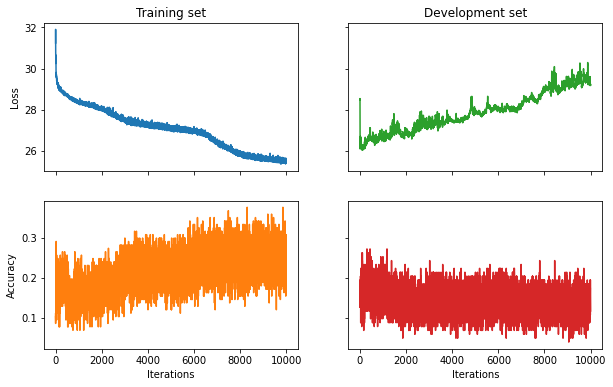

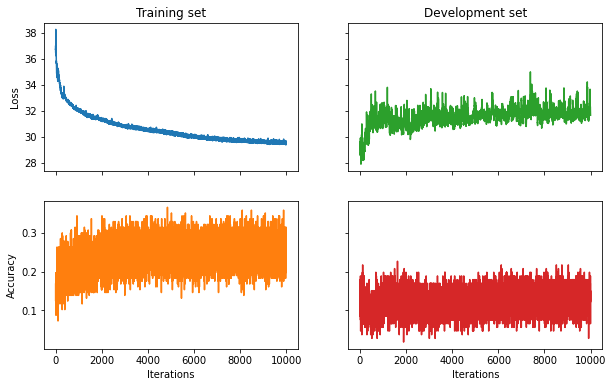

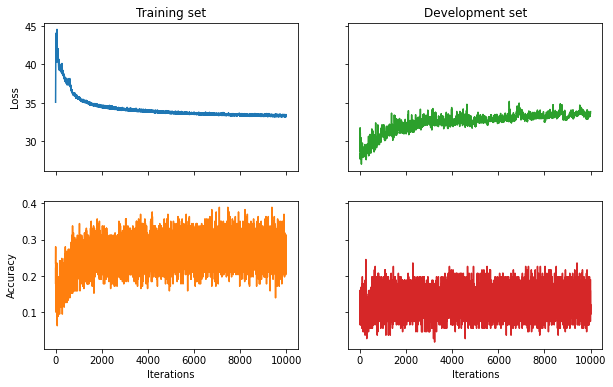

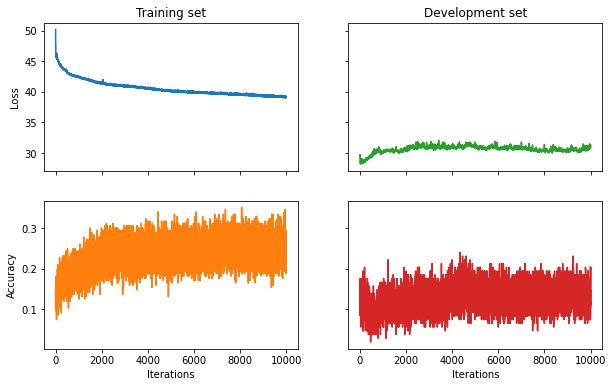

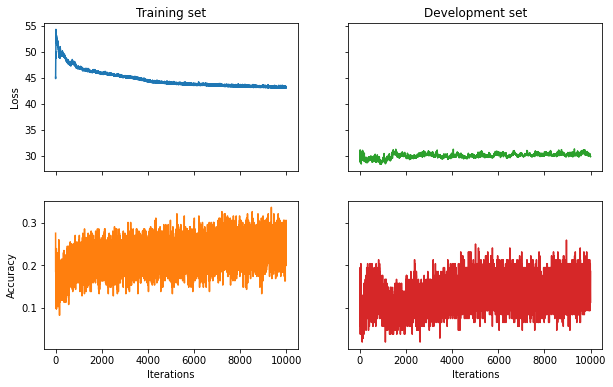

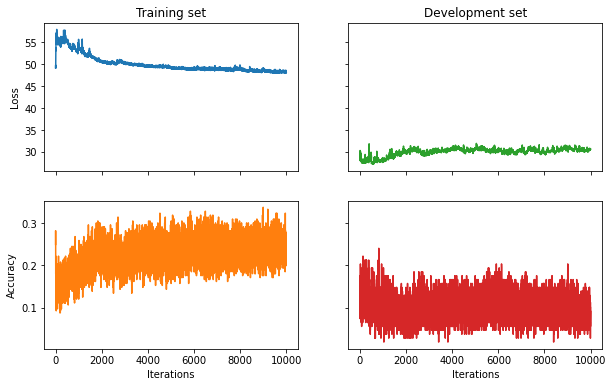

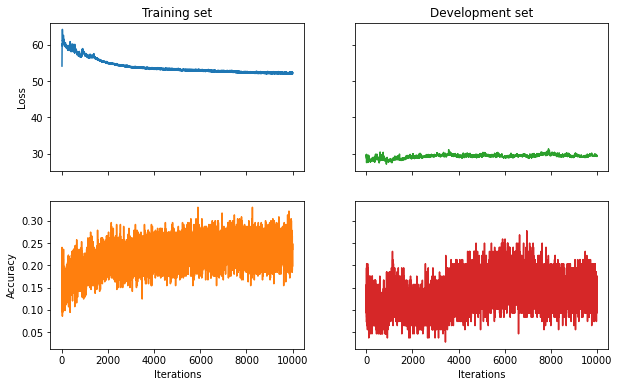

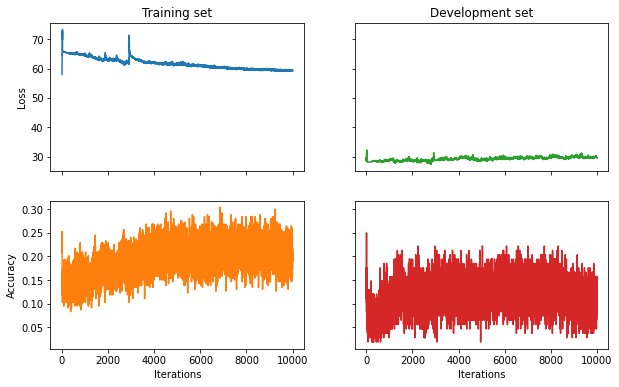

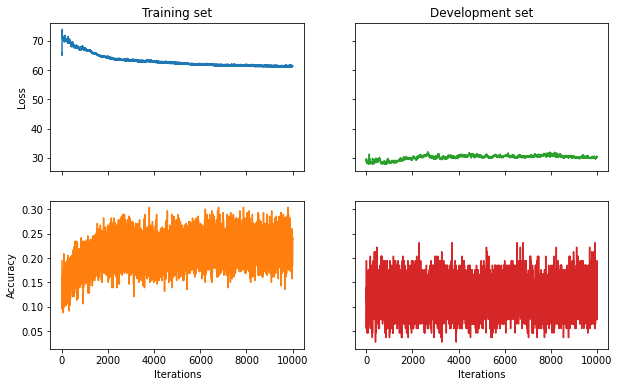

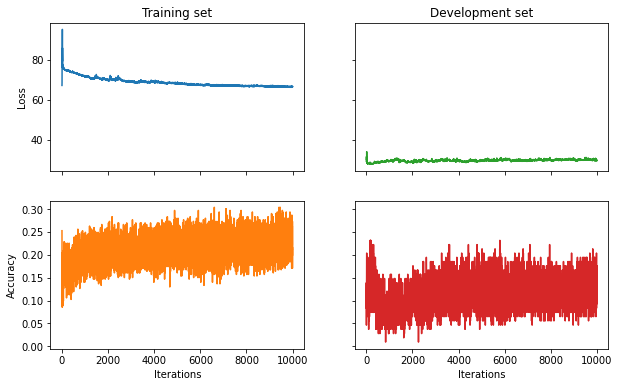

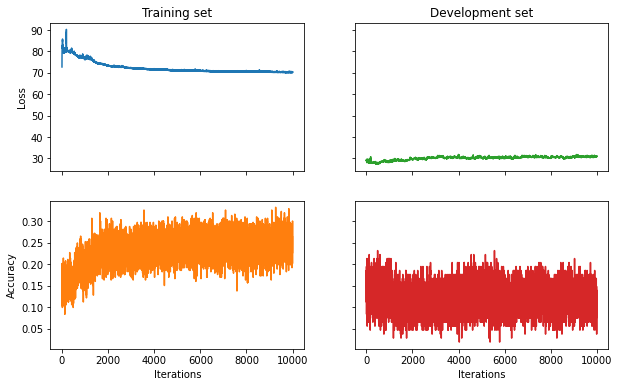

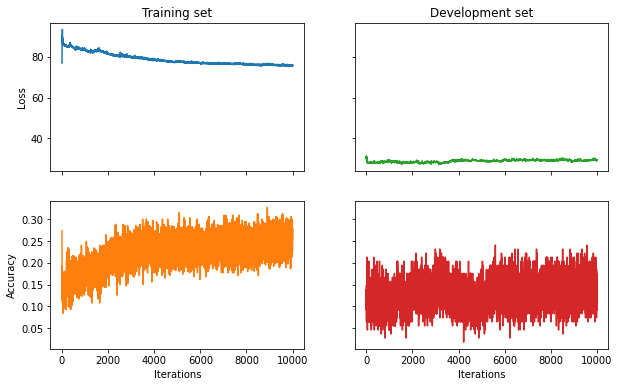

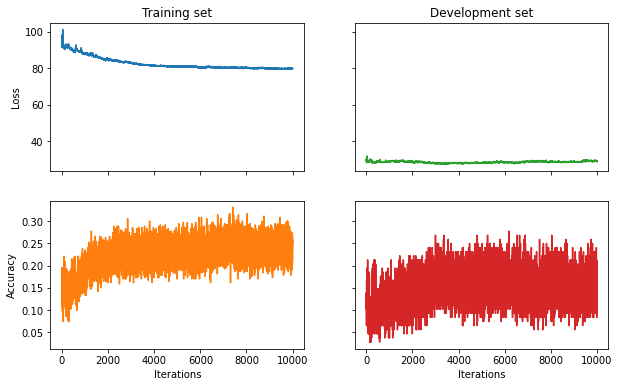

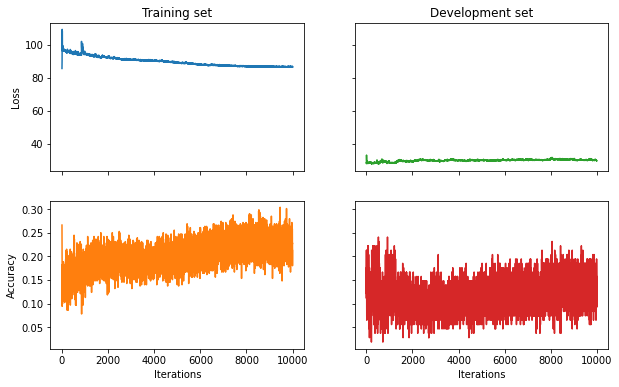

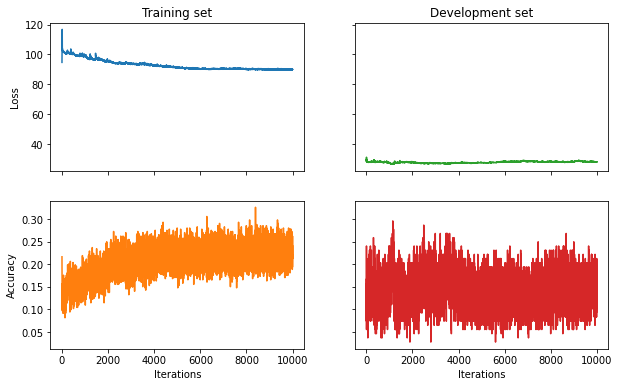

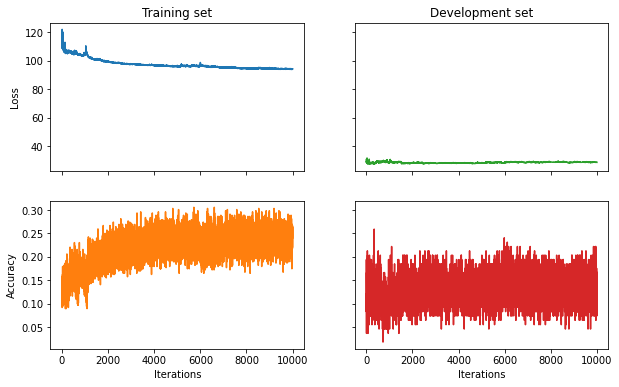

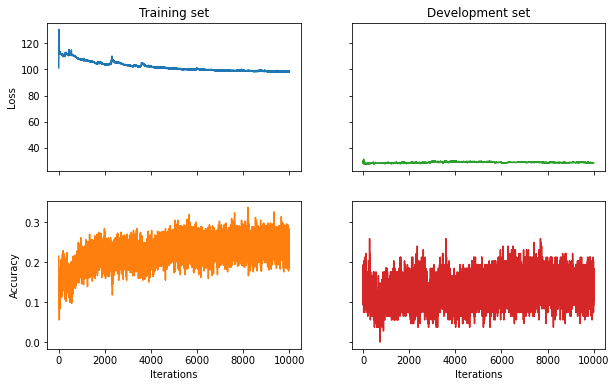

In [ ]:
result = None

for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    optimization_interval = 20
    
    if result == None or run % optimization_interval == 0:
    
        train_pred_fn = jit(make_pred_fn(training_circuits_l))
        dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
        test_pred_fn = make_pred_fn(test_circuits_l)

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        def callback_fn(xk):
            #print(xk)
            valid_loss = dev_cost_fn(xk)
            train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
            train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
            valid_acc = numpy.around(float(dev_accs[-1]), 4)
            iters = int(len(train_accs)/2)
            if iters % 200 == 0:
                info = f"Epoch: {iters}   "\
                + f"train/loss: {train_loss}   "\
                + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
                + f"train/acc: {train_acc}   "\
                + f"valid/acc: {valid_acc}"

                with open("results//" + result_file + ".txt", "a") as f:
                    f.write(info + "\n")

                print(info, file=sys.stderr)
            return valid_loss

        #a_value = 0.0053
        #c_value = 0.0185

        # Good
        #a_value = 0.053
        #c_value = 0.00185
        
        a_value = 0.01 #*(1/run)
        c_value = 0.01 #*(1/run)
        
        a_values = [0.1, 0.01, 0.001, 0.0001]
        c_values = [1, 0.1, 0.01, 0.001, 0.0001]
        
        print(a_value, c_value)
        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
        
        #for a_value in a_values:
        #    for c_value in c_values:
        #print(a_value, c_value)
        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

        figure_path = this_folder + "//results//" + result_file + ".png"
        visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)